# Downscaled `tasmax` exploration

This notebook is for exploring downscaled maximum temperature (tasmax) data. It was designed to work with the zarr outputs from the 4km ERA5-based CMIP6 downscaling effort. 

In [ ]:
# Set ERA5_DIR, CMIP6_DIR, and ADJ_DIR environment variables to your paths
# export ERA5_DIR=/path/to/cmip6_4km_downscaling/era5_zarr
# export CMIP6_DIR=/path/to/cmip6_4km_downscaling/cmip6_zarr
# export ADJ_DIR=/path/to/cmip6_4km_downscaling/adjusted

# Pass parameters via command line arguments like so, for example:
# papermill downscaled_tasmax.ipynb output.ipynb -p models 'EC-Earth3-Veg' -p scenarios 'historical ssp370 ssp585' -p temp_threshold 34
models = "EC-Earth3-Veg"
scenarios = "historical ssp370 ssp585"
temp_threshold = 34

In [2]:
# Parameters
models = "EC-Earth3-Veg"
scenarios = "historical ssp370 ssp585"
temp_threshold = 34


In [3]:
import math
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from pathlib import Path
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt
import gc
from baeda import projected_coords
from IPython.display import Markdown

import warnings
warnings.filterwarnings('ignore')

models = models.split(" ")
scenarios = scenarios.split(" ")

ref_dir = Path(
    os.getenv("ERA5_DIR", "/beegfs/CMIP6/crstephenson/cmip6_4km_downscaling/era5_zarr")
)

cmip6_dir = Path(
    os.getenv("CMIP6_DIR", "/beegfs/CMIP6/crstephenson/cmip6_4km_downscaling/cmip6_zarr")
)

adj_dir = Path(
    os.getenv("ADJ_DIR", "/beegfs/CMIP6/crstephenson/cmip6_4km_downscaling/adjusted")
)

In [4]:
def open_tasmax(model, scenario):
    zarr_store = adj_dir.joinpath(f"tasmax_{model}_{scenario}_adjusted.zarr")
    ds = xr.open_zarr(zarr_store)
    tasmax = convert_units_to(ds.tasmax, "degC")
    return tasmax


def plot_adj_tasmax(model, scenario, tasmax):
    """Plot maps and histograms of adjusted (downscaled) data highlighting high temperature pixels."""
    # Compute the mean tasmax over time
    tasmax_mean = tasmax.mean("time")

    tasmax_high = tasmax > temp_threshold
    tasmax_high_count = tasmax_high.sum("time")

    # Prepare values for histogram
    tasmax_high_values = tasmax.where(tasmax_high).values.flatten()
    tasmax_high_values = tasmax_high_values[~np.isnan(tasmax_high_values)]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"High tasmax analysis for {model}, {scenario}", fontsize=14)

    # Plot the mean tasmax as a muted background
    axs[0].imshow(
        tasmax_mean.transpose("y", "x").values,
        cmap="Greys",
        alpha=0.5,
        interpolation="none",
    )

    # Overlay the hot day counts using a blue color palette, masking zeros for clarity
    masked_hot = np.ma.masked_where(
        tasmax_high_count.transpose("y", "x") == 0, tasmax_high_count.transpose("y", "x")
    )
    im = axs[0].imshow(masked_hot, cmap="Blues", alpha=0.8, interpolation="none")

    plt.colorbar(im, ax=axs[0], label=f"Count of pixel means > {temp_threshold}°C (blue overlay)")
    axs[0].set_title(f"Mean tasmax (grey) with means > {temp_threshold}°C (blue overlay)")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Histogram subplot
    if tasmax_high_values.size > 0:
        axs[1].hist(tasmax_high_values, bins=30, color="blue", alpha=0.7)
        axs[1].set_xlabel("tasmax (°C)")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title(f"Histogram of daily (non-mean) tasmax values > {temp_threshold}°C")
        percent_above_threshold = temp_threshold * tasmax_high_values.size / tasmax.size
        axs[1].text(
            0.98,
            0.98,
            (
                f"{percent_above_threshold:.3f}% > {temp_threshold}°C"
                if np.round(percent_above_threshold, 3) > 0
                else f"~0% > {temp_threshold}°C"
            ),
            ha="right",
            va="top",
            transform=axs[1].transAxes,
            fontsize=12,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )
    else:
        axs[1].text(
            0.5,
            0.5,
            f"No tasmax values above {temp_threshold}°C found.",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    del tasmax

    gc.collect()


def get_top6_hot_pixels(tasmax):
    tasmax = tasmax.transpose("y", "x", "time")
    tasmax_high_count = (tasmax > temp_threshold).sum(dim="time").load()

    # Get the array positions of the top 6 values in tasmax_high_count.
    top6_yx = np.unravel_index(np.argsort(tasmax_high_count.values.ravel())[-6:], tasmax_high_count.shape)

    # Get the corresponding map coordinates and reverse order for descending list.
    top6_x = tasmax_high_count.x.values[top6_yx[1]][::-1]
    top6_y = tasmax_high_count.y.values[top6_yx[0]][::-1]

    return list(zip(top6_x, top6_y))


def plot_top6_high_pixels(model, scenario, tasmax, top6_pixels):
    tasmax_mean = tasmax.mean("time")
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    tasmax_mean.transpose("y", "x").plot(ax=ax, cmap="Greys")
    top6_x, top6_y = zip(*top6_pixels)
    ax.scatter(top6_x, top6_y, color="blue", s=5, label=f"Top 6 high temperature pixels (most occurrences of >{temp_threshold}°C)")
    plt.title(f"Mean tasmax (grey) with top 6 pixels > {temp_threshold}°C (blue) for {model}, {scenario}", pad=20)
    plt.legend()
    plt.show()


def plot_top6_high_ecdfs(
    era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, top6_pixels, thresh=None, names=None
):
    n = len(top6_pixels)
    ncols = math.ceil(n / 2)
    nrows = 2

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharey=True)
    axs = axs.flatten()

    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    for i, (x, y) in enumerate(top6_pixels):
        era5_extr = convert_units_to(
            era5_ds.t2max.sel(x=x, y=y, method="nearest").rename("tasmax"), "degC"
        )
        hist_extr = convert_units_to(
            hist_ds.tasmax.sel(x=x, y=y, method="nearest"), "degC"
        )
        sim_extr = convert_units_to(
            sim_ds.tasmax.sel(x=x, y=y, method="nearest"), "degC"
        )
        tasmax_historical_extr = tasmax_historical.sel(x=x, y=y, method="nearest").load()
        tasmax_extr = tasmax.sel(x=x, y=y, method="nearest").load()

        max_doy = tasmax_extr.time[tasmax_extr.argmax(dim="time")].dt.dayofyear.item()
        doys = list(range(max_doy - 15, max_doy)) + list(range(max_doy, max_doy + 15))

        window_df = pd.concat(
            [
                era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source="ERA5")
                .to_dataframe()
                .reset_index(),
                hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_historical")
                .to_dataframe()
                .reset_index(),
                sim_extr.sel(time=sim_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_{scenario}")
                .to_dataframe()
                .reset_index(),
                tasmax_historical_extr.sel(time=tasmax_historical_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_historical_downscaled")
                .to_dataframe()
                .reset_index(),
                tasmax_extr.sel(time=tasmax_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_{scenario}_downscaled")
                .to_dataframe()
                .reset_index(),
            ]
        )[["time", "source", "tasmax"]]

        # Solves "cannot reindex on an axis with duplicate labels" erros when plotting.
        window_df.reset_index(inplace=True)

        color_mapping = {
            "ERA5": "black",
            f"{model}_historical": "lightblue",
            f"{model}_{scenario}": "lightgreen",
            f"{model}_historical_downscaled": "blue",
            f"{model}_{scenario}_downscaled": "green",
        }
        sns.ecdfplot(
            data=window_df,
            x="tasmax",
            hue="source",
            ax=axs[i],
            palette=color_mapping,
        )
        if thresh:
            axs[i].set_xlim(left=thresh)
        if names is None:
            title = f"Pixel {i+1}\n(x={x:.0f}, y={y:.0f})"
        else:
            title = names[i]
        axs[i].set_title(title)
        axs[i].set_xlabel("tasmax (°C)")
        if i % ncols == 0:
            axs[i].set_ylabel("ECDF")
        else:
            axs[i].set_ylabel("")

    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])

    if names is None:
        suptitle = (
            f"ECDF of tasmax for top 6 high temperature pixels (most occurrences of >{temp_threshold}°C) for {model}.\n"
            f"Includes only data from 31-day window centered on the day-of-year (DOY: {max_doy}) of the maximum tasmax value (all years)"
        )
    else:
        suptitle = (
            f"ECDF of tasmax for 6 specified pixels for {model}.\n"
            f"Includes only data from 31-day window centered on the day-of-year (DOY: {max_doy}) of the maximum tasmax value (all years)"
        )
    plt.suptitle(
        suptitle,
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Compute day-of-year means for sim_ds and hist_ds
def plot_doy_means(era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, x, y):
    sim_ds["tasmax"] = convert_units_to(
        sim_ds.tasmax, "degC"
    )

    hist_ds["tasmax"] = convert_units_to(
        hist_ds.tasmax, "degC"
    )

    sim_doy_mean = sim_ds["tasmax"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time")
    hist_doy_mean = hist_ds["tasmax"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time")
    ref_doy_mean = era5_ds["t2max"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time")
    tasmax_historical_doy_mean = tasmax_historical.sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time")
    tasmax_doy_mean = tasmax.sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time")

    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    plt.figure(figsize=(9, 5))
    plt.plot(ref_doy_mean["dayofyear"], ref_doy_mean, label="ERA5", color="black")
    plt.plot(
        hist_doy_mean["dayofyear"],
        hist_doy_mean,
        label=f"{model} historical",
        color="lightblue",
    )
    plt.plot(
        sim_doy_mean["dayofyear"],
        sim_doy_mean,
        label=f"{model} {scenario}",
        color="lightgreen",
    )
    plt.plot(
        tasmax_historical_doy_mean["dayofyear"],
        tasmax_historical_doy_mean,
        label=f"{model} historical downscaled",
        color="blue",
    )
    plt.plot(
        tasmax_doy_mean["dayofyear"],
        tasmax_doy_mean,
        label=f"{model} {scenario} downscaled",
        color="green",
    )
    plt.xlabel("Day of Year")
    plt.ylabel("tasmax (°C)")
    plt.title(f"Day-of-year mean tasmax: {model}, {scenario}, pixel: (x={x}, y={y})")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_random_ecdf(base, era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, ixy=None, thresh=None):
    """plot high tasmax pixels for unadjusted CMIP6 data"""
    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    fig, axs = plt.subplots(1, 2, figsize=(13, 6))
    fig.suptitle(
        f"High tasmax analysis for downscaled {model}, {scenario} at point location",
        fontsize=14,
    )

    # Plot the mean tasmax as a muted background
    base.plot(ax=axs[0], cmap="Greys", alpha=0.5, add_colorbar=False, x="x")

    # get a random pixel if ixy not supplied
    if ixy is None:
        random_x = np.random.choice(base.x.values)
        random_y = np.random.choice(base.y.values)
    else:
        random_x, random_y = base.x.isel(x=ixy[0]).item(), base.y.isel(y=ixy[1]).item()

    # plot the location of the random pixel
    axs[0].scatter(random_x, random_y, color="blue", s=5, label="Random Pixel")

    # extract the random pixel time series for era5_ds, hist_ds, and sim_ds
    era5_extr = convert_units_to(
        era5_ds.t2max.sel(x=random_x, y=random_y).rename("tasmax"), "degC"
    )
    hist_extr = convert_units_to(hist_ds.tasmax.sel(x=random_x, y=random_y), "degC")
    sim_extr = convert_units_to(sim_ds.tasmax.sel(x=random_x, y=random_y), "degC")
    tasmax_historical_extr = tasmax_historical.sel(x=random_x, y=random_y).load()
    tasmax_extr = tasmax.sel(x=random_x, y=random_y).load()

    # Compute the day of year for the maximum tasmax in the historical data and get window of 30 days around it
    max_doy = tasmax_historical_extr.where(
        tasmax_historical_extr == tasmax_historical_extr.max() , drop=True
    ).time.dt.dayofyear.item()
    doys = list(range(max_doy - 15, max_doy)) + list(range(max_doy, max_doy + 15))

    window_df = pd.concat(
        [
            era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source="ERA5")
            .to_dataframe()
            .reset_index(),
            hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_historical")
            .to_dataframe()
            .reset_index(),
            sim_extr.sel(time=sim_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_{scenario}")
            .to_dataframe()
            .reset_index(),
            tasmax_historical_extr.sel(time=tasmax_historical_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_historical_downscaled")
            .to_dataframe()
            .reset_index(),
            tasmax_extr.sel(time=tasmax_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_{scenario}_downscaled")
            .to_dataframe()
            .reset_index(),
        ]
    )[["time", "source", "tasmax"]]

    window_df.reset_index(inplace=True)

    color_mapping = {
        "ERA5": "black",
        f"{model}_historical": "lightblue",
        f"{model}_{scenario}": "lightgreen",
        f"{model}_historical_downscaled": "blue",
        f"{model}_{scenario}_downscaled": "green",
    }

    sns.ecdfplot(
        data=window_df,
        x="tasmax",
        hue="source",
        ax=axs[1],
        palette=color_mapping
    )
    if thresh:
        plt.xlim(left=thresh)
    axs[1].set_xlabel("tasmax (°C)")

    plt.tight_layout()
    plt.show()

    return window_df

In [5]:
era5_ds = xr.open_dataset(ref_dir.joinpath("t2max_era5.zarr"))
era5_ds["t2max"] = convert_units_to(
    era5_ds.t2max, "degC"
)

### Choose hand-picked places

In [6]:
places1 = ["Fairbanks", "Anchorage", "Nome", "Yakutat", "Utqiagvik", "near_McGrath"]
pixels1 = [(projected_coords[k]["x"], projected_coords[k]["y"]) for k in places1]

places2 = [
    "near_McGrath",
    "near_Arctic_Village",
    "warmest",
    "coldest",
    "wettest",
    "driest",
]
pixels2 = [(projected_coords[k]["x"], projected_coords[k]["y"]) for k in places2]

# EC-Earth3-Veg

## EC-Earth3-Veg, historical

### High tasmax analysis

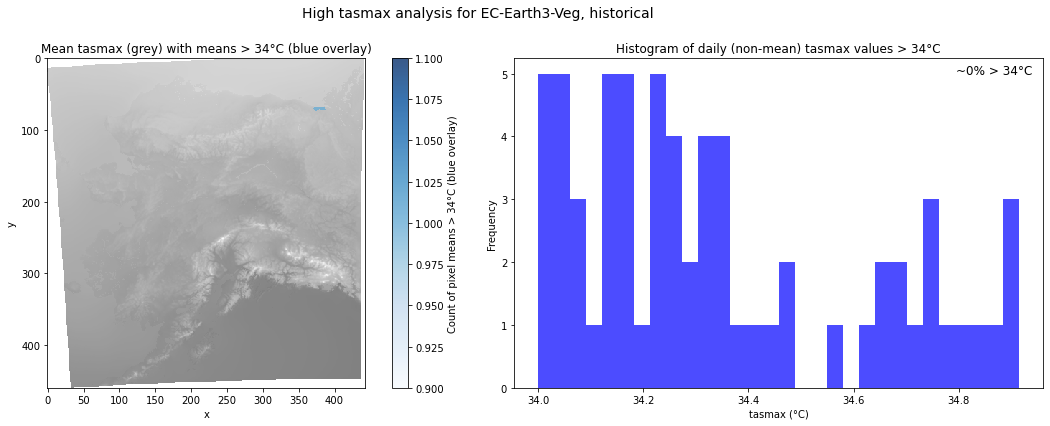

### Top 6 pixels with highest tasmax

Top 6 (x, y) coordinates with highest counts of days > 34°C:


1. (x: 699656.90, y: 2199656.89), count above 34°C: 1


2. (x: 707674.55, y: 2203665.71), count above 34°C: 1


3. (x: 711683.38, y: 2203665.71), count above 34°C: 1


4. (x: 663577.49, y: 2191639.24), count above 34°C: 1


5. (x: 667586.31, y: 2191639.24), count above 34°C: 1


6. (x: 671595.14, y: 2191639.24), count above 34°C: 1


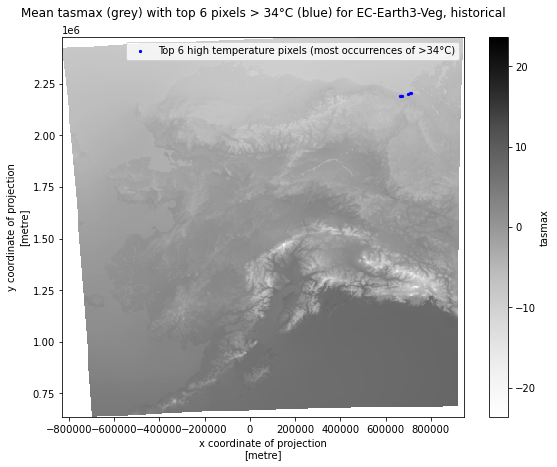

## EC-Earth3-Veg, ssp370

### High tasmax analysis

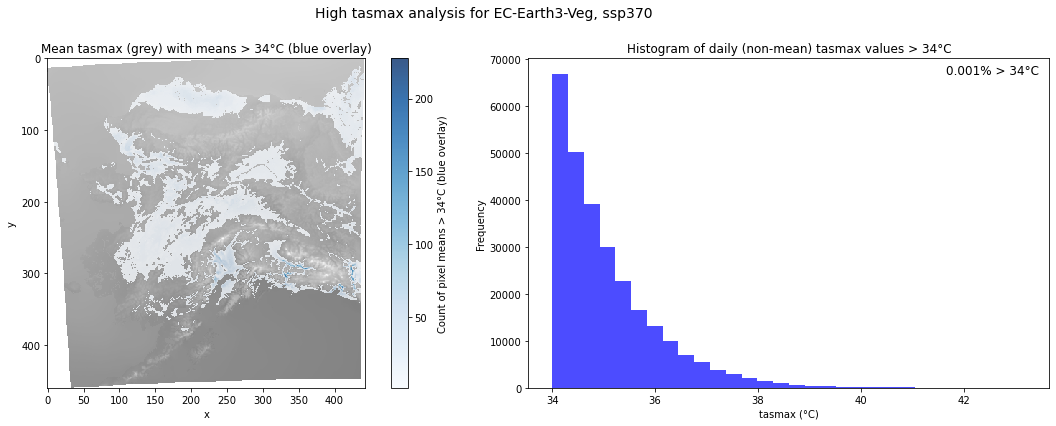

### Top 6 pixels with highest tasmax

Top 6 (x, y) coordinates with highest counts of days > 34°C:


1. (x: 499215.69, y: 1265600.84), count above 34°C: 228


2. (x: 503224.52, y: 1261592.01), count above 34°C: 170


3. (x: 815912.81, y: 1193442.00), count above 34°C: 166


4. (x: 499215.69, y: 1261592.01), count above 34°C: 164


5. (x: 819921.63, y: 1197450.83), count above 34°C: 159


6. (x: 503224.52, y: 1265600.84), count above 34°C: 156


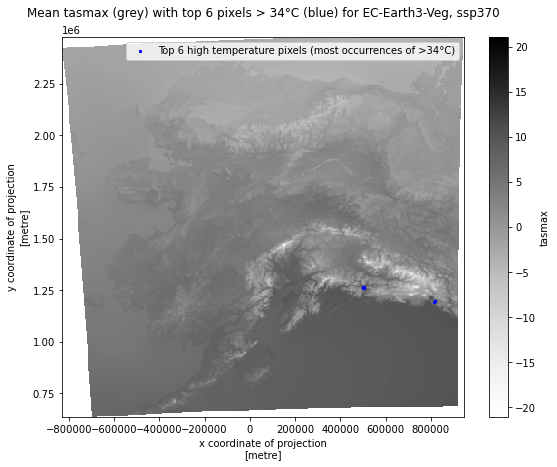

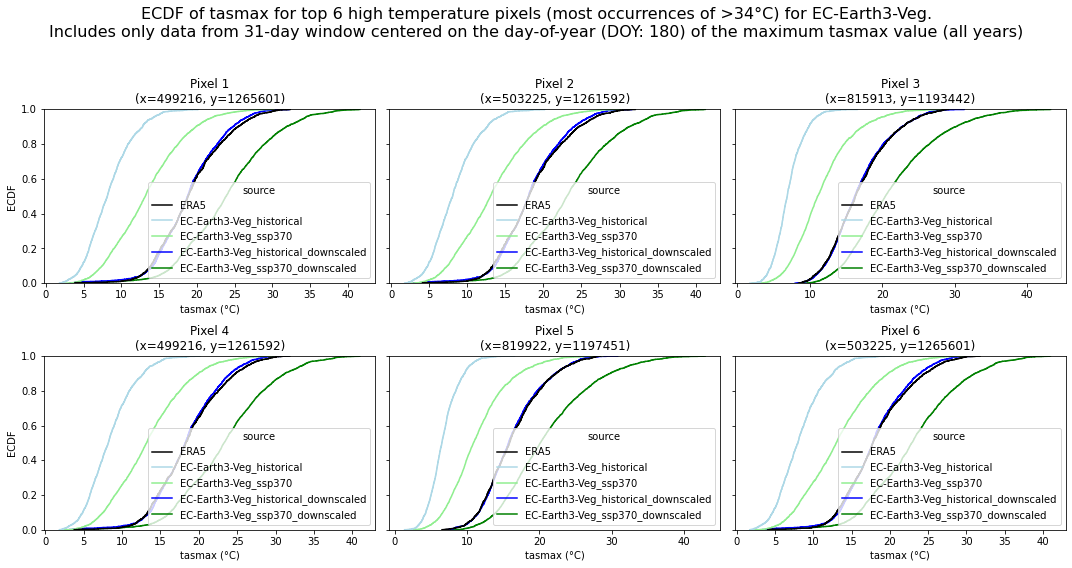

### Hand-picked places

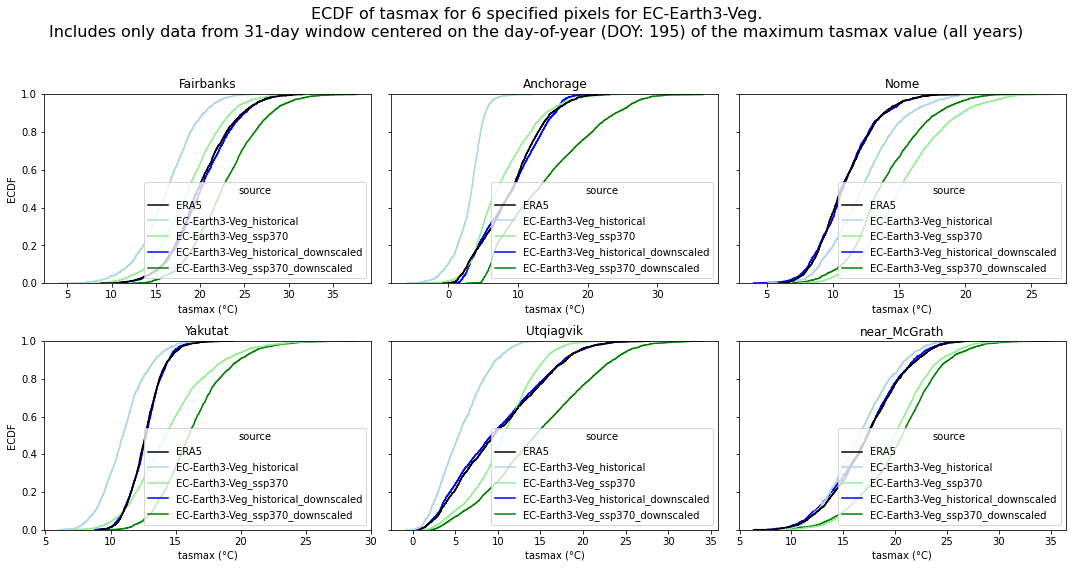

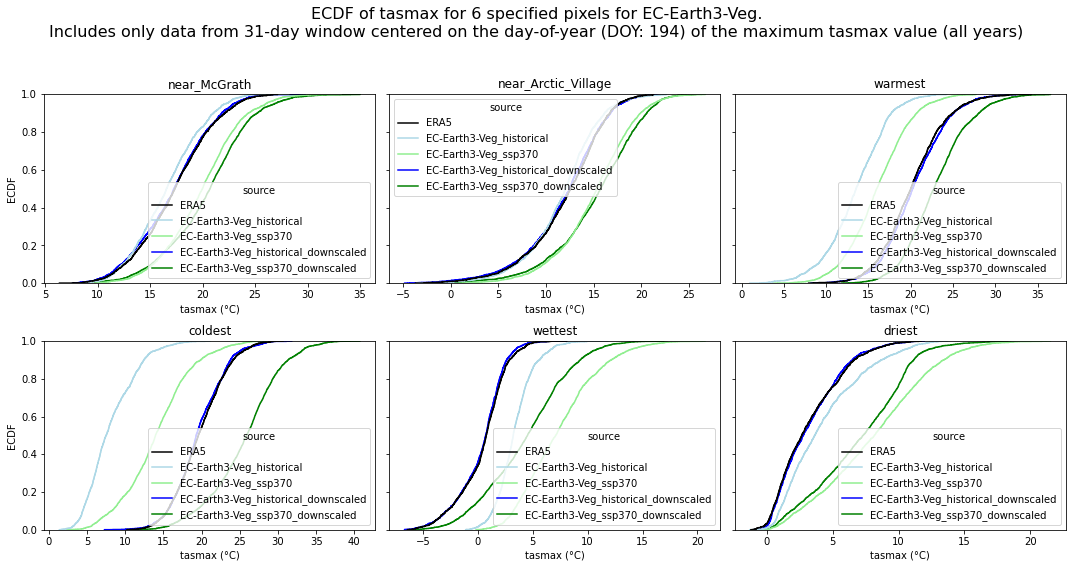

### Day-of-year (DOY) means

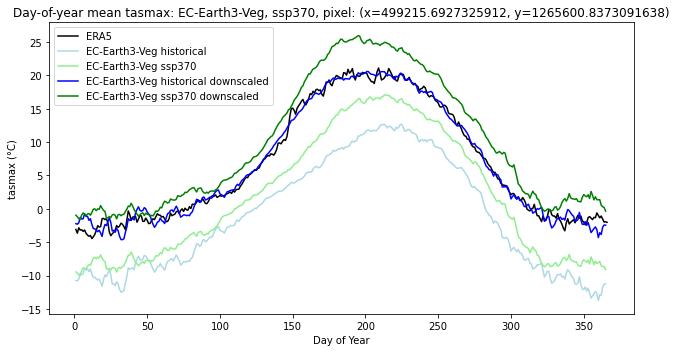

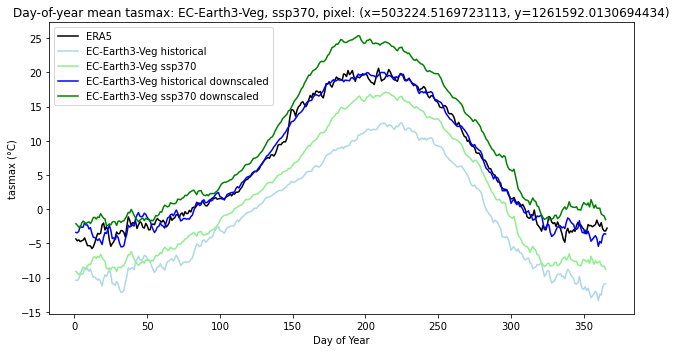

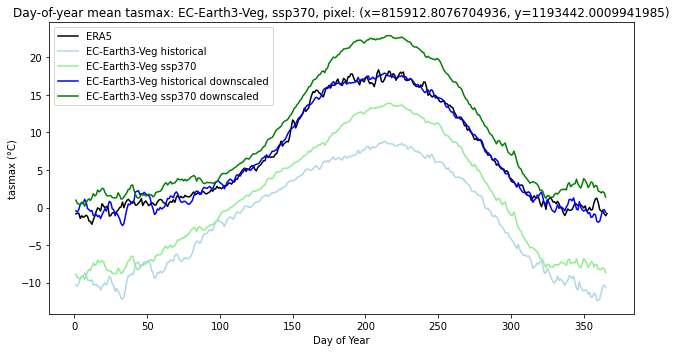

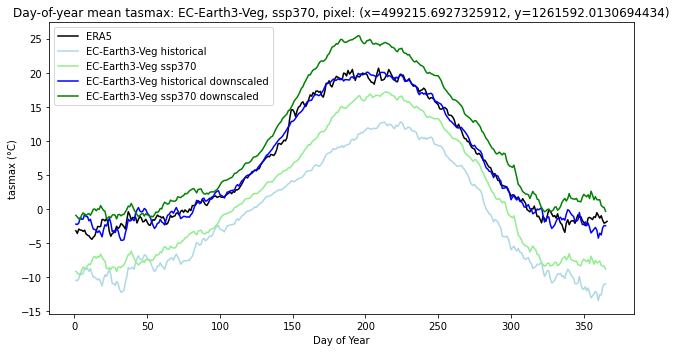

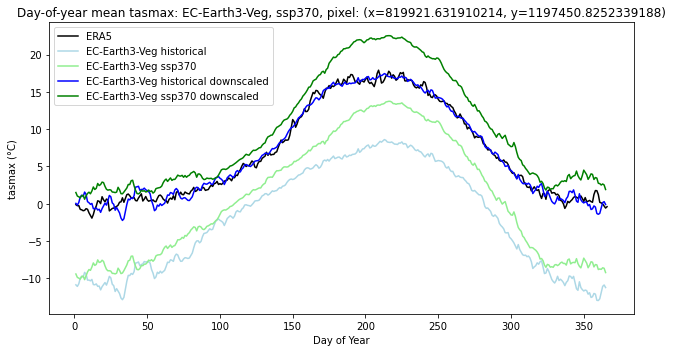

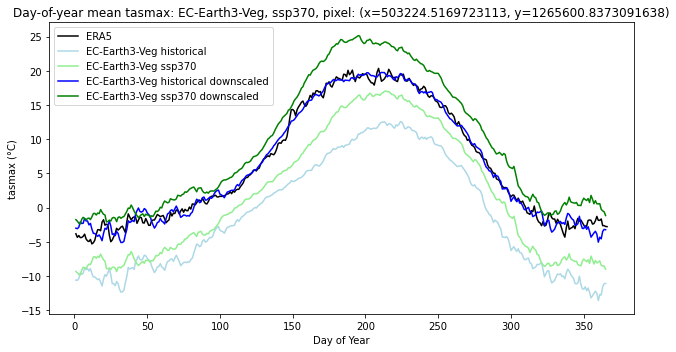

### Arbitrary locations

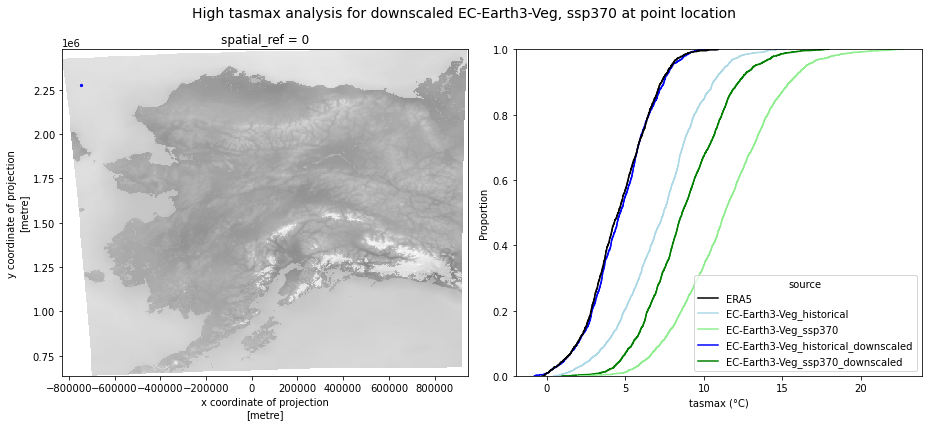

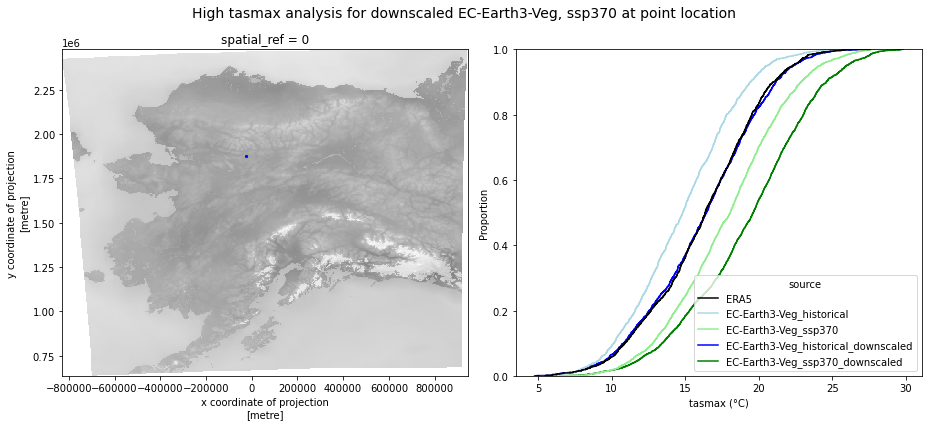

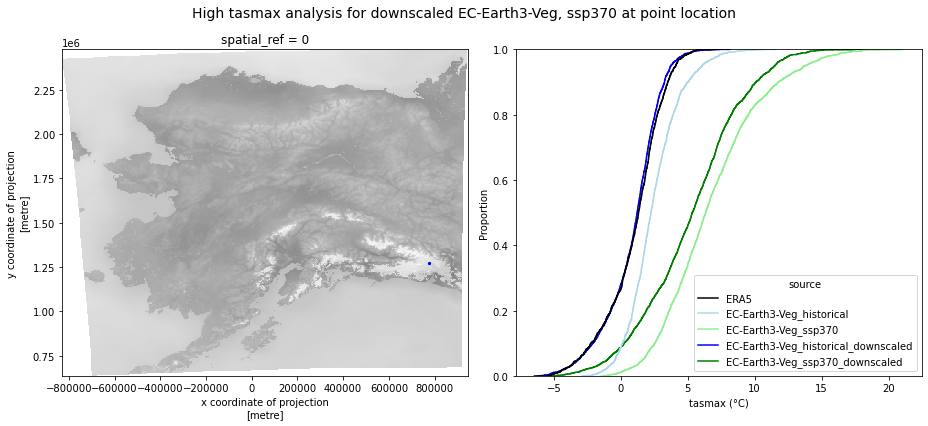

## EC-Earth3-Veg, ssp585

### High tasmax analysis

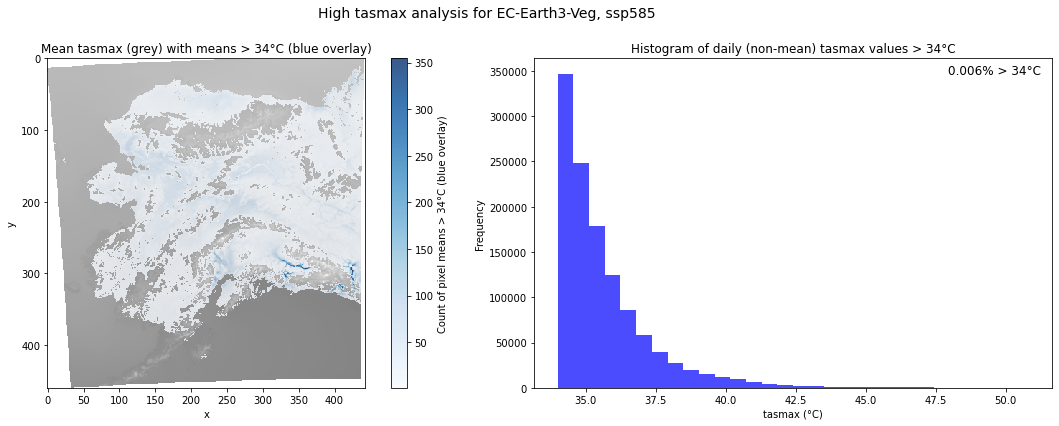

### Top 6 pixels with highest tasmax

Top 6 (x, y) coordinates with highest counts of days > 34°C:


1. (x: 615471.60, y: 1301680.26), count above 34°C: 355


2. (x: 499215.69, y: 1265600.84), count above 34°C: 348


3. (x: 872036.35, y: 1297671.43), count above 34°C: 347


4. (x: 880054.00, y: 1321724.38), count above 34°C: 347


5. (x: 876045.17, y: 1289653.78), count above 34°C: 346


6. (x: 872036.35, y: 1301680.26), count above 34°C: 345


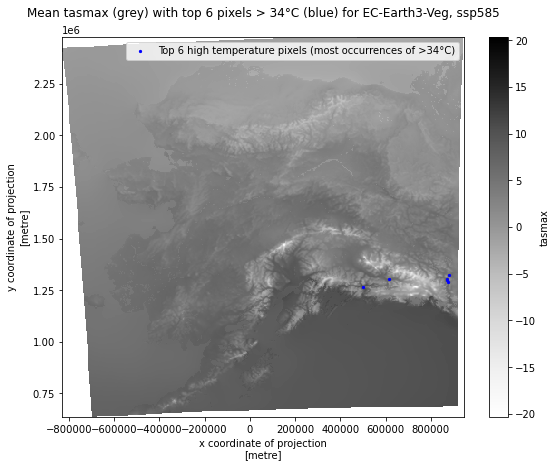

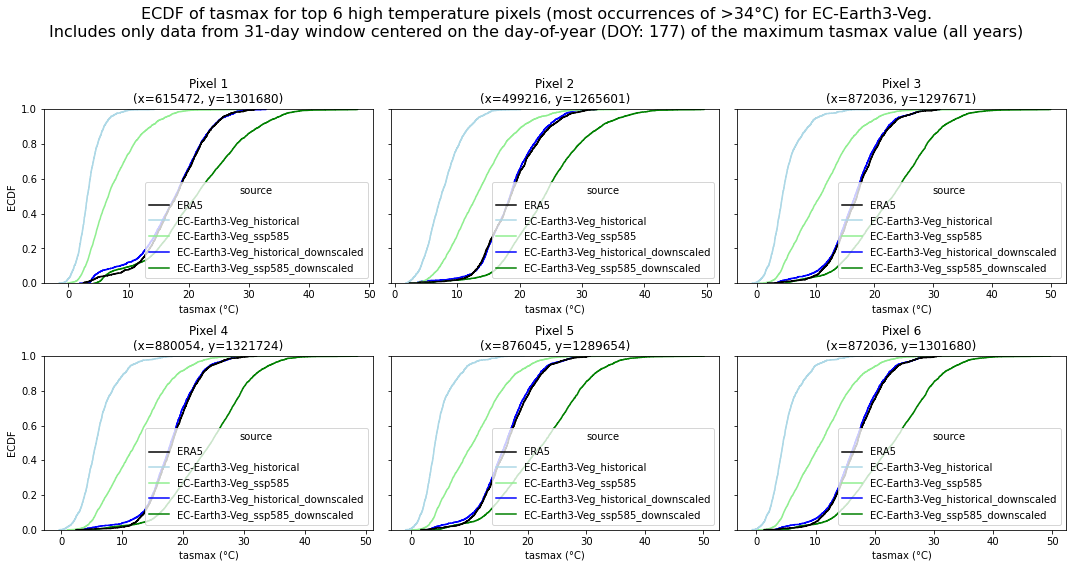

### Hand-picked places

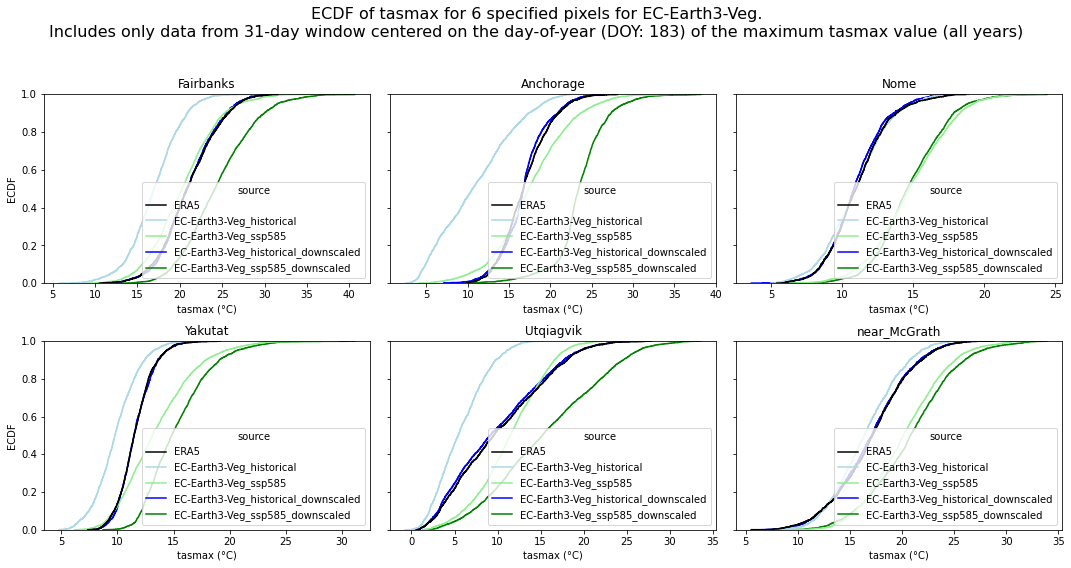

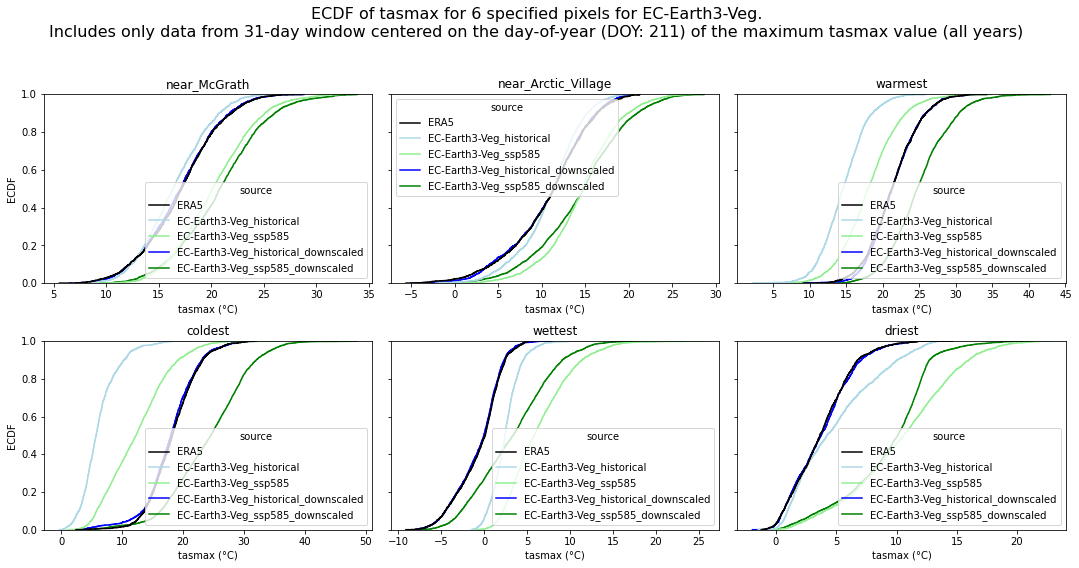

### Day-of-year (DOY) means

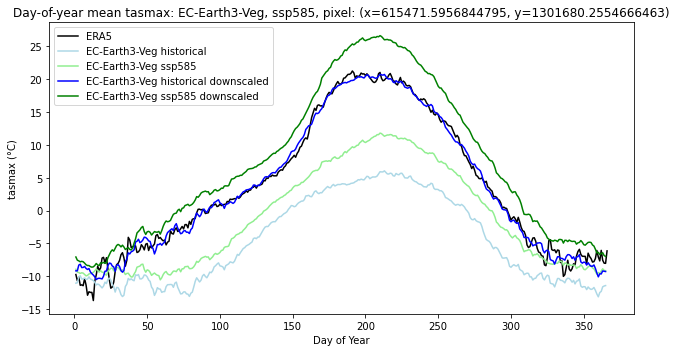

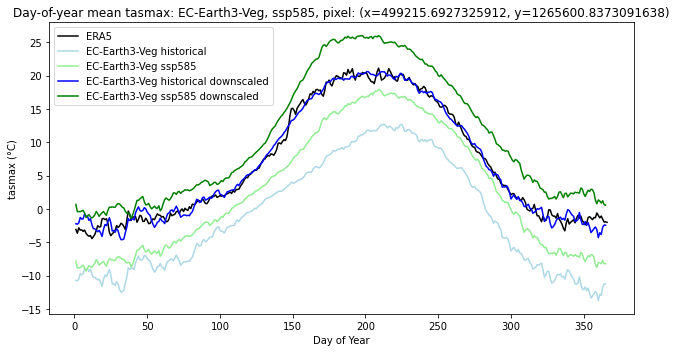

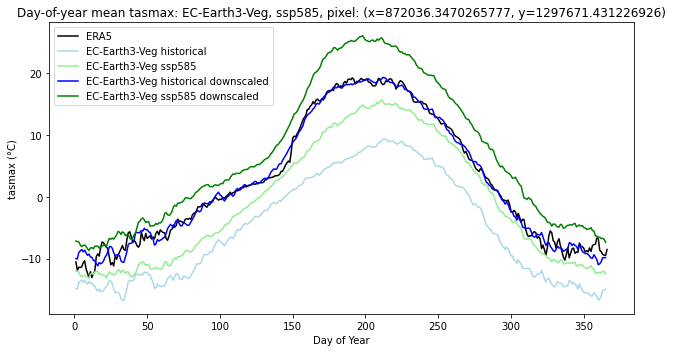

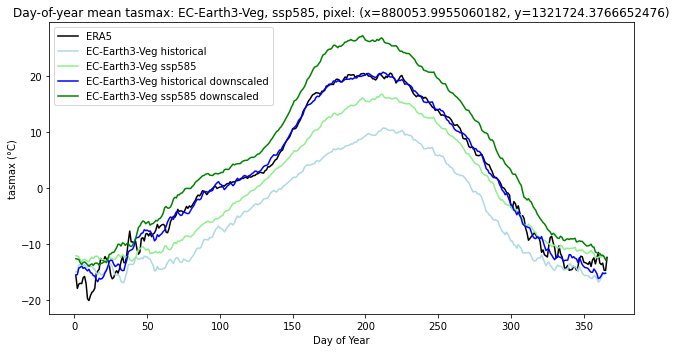

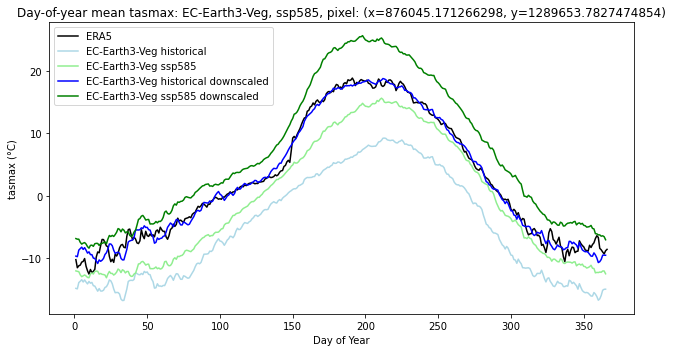

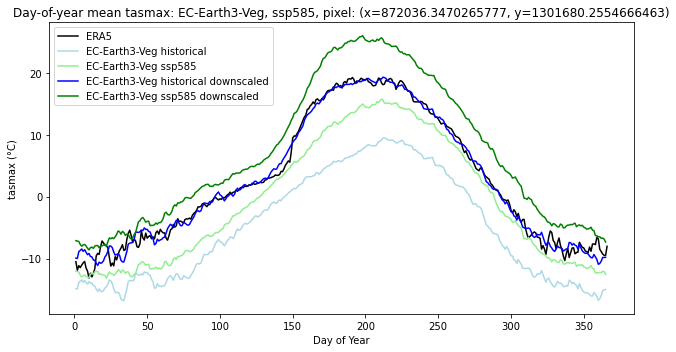

### Arbitrary locations

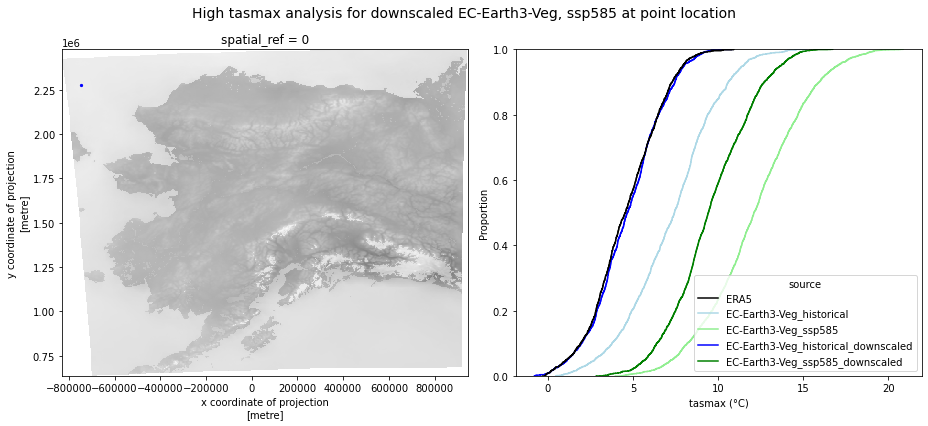

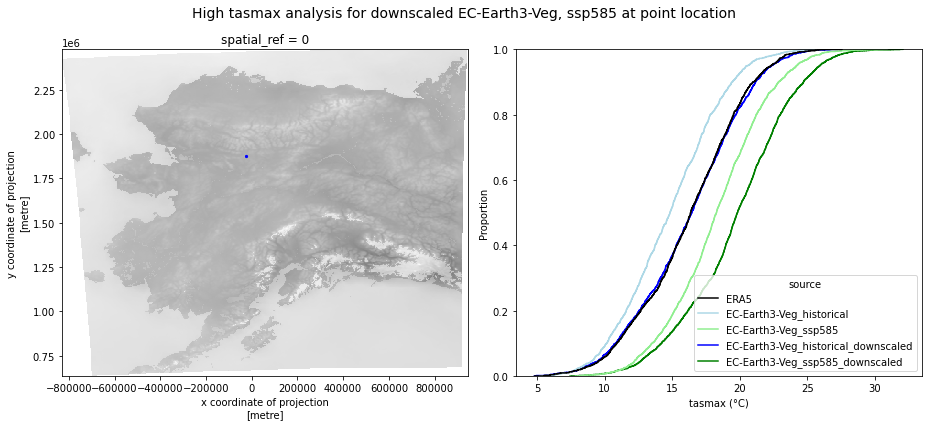

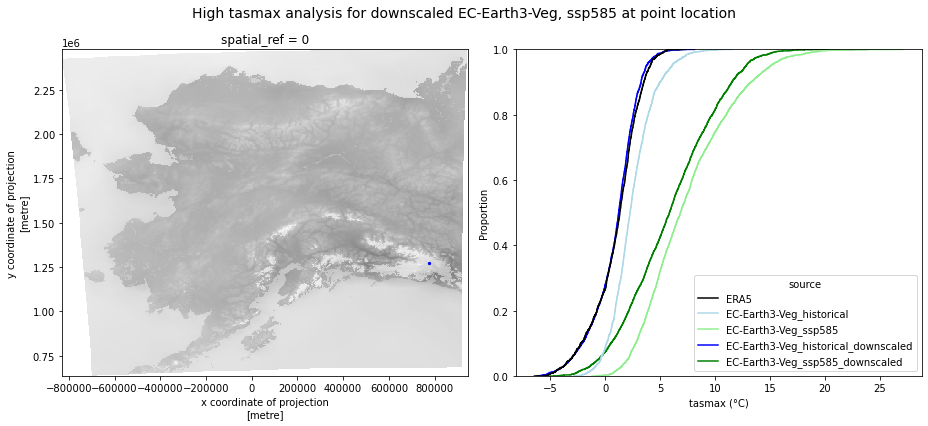

In [7]:
for model in models:
    display(Markdown(f"# {model}"))
    hist_ds = xr.open_dataset(cmip6_dir.joinpath(f"tasmax_{model}_historical.zarr"))
    tasmax_historical = open_tasmax(model, "historical")

    for scenario in scenarios:
        display(Markdown(f"## {model}, {scenario}"))
        sim_ds = xr.open_dataset(cmip6_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))
    
        display(Markdown(f"### High tasmax analysis"))
        tasmax = open_tasmax(model, scenario)
        plot_adj_tasmax(model, scenario, tasmax)

        display(Markdown(f"### Top 6 pixels with highest tasmax"))
        top6_pixels = get_top6_hot_pixels(tasmax)
        print(f"Top 6 (x, y) coordinates with highest counts of days > {temp_threshold}°C:")
        for idx, (x, y) in enumerate(top6_pixels, start=1):
            print(
                f"{idx}. (x: {x:.2f}, y: {y:.2f}), count above {temp_threshold}°C: {(tasmax.sel(x=x, y=y).values > temp_threshold).sum()}"
            )
        plot_top6_high_pixels(model, scenario, tasmax, top6_pixels)

        if scenario != "historical":
            plot_top6_high_ecdfs(era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, top6_pixels)
    
            display(Markdown(f"### Hand-picked places"))
            plot_top6_high_ecdfs(era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, pixels1, names=places1)
            plot_top6_high_ecdfs(era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, pixels2, names=places2)

            display(Markdown(f"### Day-of-year (DOY) means"))
            for i in range(6):
                plot_doy_means(
                    era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, x=top6_pixels[i][0], y=top6_pixels[i][1]
                )

            display(Markdown(f"### Arbitrary locations"))
            base = tasmax.max("time")
            for ixy in [(20, 50), (200, 150), (400, 300)]:
                plot_random_ecdf(base, era5_ds, hist_ds, sim_ds, tasmax_historical, tasmax, ixy=ixy)